In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Detected: {gpu.device_type} - {gpu.name}")
else:
    print("No GPU detected")

2024-05-14 22:32:22.141287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 22:32:27.650622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jhuang/miniconda3/envs/venv/lib:/home/jhuang/miniconda3/envs/venv/nvvm/libdevice:/home/jhuang/miniconda3/envs/venv/lib:/home/jhuang/miniconda3/envs/venv/nvvm/libdevice::/home/jhuang/miniconda3/envs/venv/lib/
2024-05-14 22:32:27.650722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

GPU Detected: GPU - /physical_device:GPU:0
GPU Detected: GPU - /physical_device:GPU:1


# All data

## Load

In [2]:
# Read data form csv
train_df = pd.read_csv("data/train_df.csv")
valid_df = pd.read_csv("data/valid_df.csv")
test_df = pd.read_csv("data/test_df.csv")
train_df.shape, valid_df.shape, test_df.shape

((28561, 3), (3579, 3), (3574, 3))

In [3]:
# Load and normalize images
def load_images(data, base_path):
    images = []
    labels = []
    paths = []
    
    # Mapping from Usage to directory names
    directory_map = {
        "Training": "FER2013Train",
        "PublicTest": "FER2013Valid",
        "PrivateTest": "FER2013Test"
    }
    
    for idx, row in data.iterrows():
        directory = directory_map.get(row['Usage'], None)
        if directory:
            image_path = os.path.join(base_path, directory, row['Image name'])
            
            if os.path.exists(image_path):
                # Load the image
                image = Image.open(image_path).convert('L')  # Convert to grayscale
                image_array = np.array(image) / 255.0  # Normalize to 0-1
                
                # Append data
                images.append(image_array)
                labels.append(row['predominant_emotion_index'])  # Select emotion intensity columns
                paths.append(image_path)
    
    return np.array(images), np.array(labels), paths

# Base path for images
base_image_path = 'FERPlus-master/data'

# Load images and their labels
train_images, train_labels, train_image_paths = load_images(train_df, base_image_path)
valid_images, valid_labels, valid_image_paths = load_images(valid_df, base_image_path)
test_images, test_labels, test_image_paths = load_images(test_df, base_image_path)

# Check shapes and an example path
print("Train images shape:", train_images.shape, train_images.dtype)
print("Train labels shape:", train_labels.shape, train_labels.dtype)

print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)

print("Tests images shape:", test_images.shape, test_images.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)


Train images shape: (28561, 48, 48) float64
Train labels shape: (28561,) int64
Valid images shape: (3579, 48, 48) float64
Valid labels shape: (3579,) int64
Tests images shape: (3574, 48, 48) float64
Tests labels shape: (3574,) int64


# Basic CNN

In [4]:
# Create a basic CNN model
basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # first conv layer
    MaxPooling2D((2, 2)),  # first pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # second conv layer
    MaxPooling2D((2, 2)),  # second pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # third conv layer
    MaxPooling2D((2, 2)),  # third pooling layer
    Flatten(),  # flatten the output for the dense layer
    Dense(128, activation='relu'),  # fully connected layer
    Dropout(0.5),  # dropout for regularization
    Dense(10, activation='softmax')  # output layer with 10 units for each emotion
])

basic_model.summary()  # This will print the summary of the model architecture

2024-05-14 22:32:45.816232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 22:32:52.572452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9932 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:17:00.0, compute capability: 7.0
2024-05-14 22:32:52.591932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7251 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [5]:
# Compile the model
basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Reshape images to add channel dimension for CNN

In [6]:
# Reshape or modify the data to add a channel dimension for CNNs, expect an input shape like (batch, height, width, channels)
# Channel dimension is 1 for grayscale images
train_images = train_images.reshape((-1, 48, 48, 1))
valid_images = valid_images.reshape((-1, 48, 48, 1))
test_images = test_images.reshape((-1, 48, 48, 1))

In [7]:
print("Train images shape:", train_images.shape, train_images.dtype)
print("Train labels shape:", train_labels.shape, train_labels.dtype)

print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)

print("Tests images shape:", test_images.shape, test_images.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)

Train images shape: (28561, 48, 48, 1) float64
Train labels shape: (28561,) int64
Valid images shape: (3579, 48, 48, 1) float64
Valid labels shape: (3579,) int64
Tests images shape: (3574, 48, 48, 1) float64
Tests labels shape: (3574,) int64


## Fit model

In [8]:
# Fit the model
basic_model_history = basic_model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(valid_images, valid_labels)
)

2024-05-14 22:32:55.096122: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 263218176 exceeds 10% of free system memory.
2024-05-14 22:32:55.363234: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 263218176 exceeds 10% of free system memory.


Epoch 1/30


2024-05-14 22:33:01.344386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-14 22:33:03.722186: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x564101113b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-14 22:33:03.722217: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2024-05-14 22:33:03.722222: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-05-14 22:33:04.074899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 22:33:05.813686: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


447/447 [==============================] - ETA: 0s - loss: 1.6050 - accuracy: 0.3961

2024-05-14 22:33:09.724471: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 32984064 exceeds 10% of free system memory.
2024-05-14 22:33:09.771898: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 32984064 exceeds 10% of free system memory.


447/447 [==============================] - 14s 6ms/step - loss: 1.6050 - accuracy: 0.3961 - val_loss: 1.3912 - val_accuracy: 0.5312
Epoch 2/30
447/447 [==============================] - 3s 6ms/step - loss: 1.3293 - accuracy: 0.5471 - val_loss: 1.1606 - val_accuracy: 0.5977
Epoch 3/30
447/447 [==============================] - 3s 6ms/step - loss: 1.1639 - accuracy: 0.6056 - val_loss: 1.0586 - val_accuracy: 0.6390
Epoch 4/30
447/447 [==============================] - 2s 6ms/step - loss: 1.0618 - accuracy: 0.6391 - val_loss: 0.9791 - val_accuracy: 0.6650
Epoch 5/30
447/447 [==============================] - 2s 6ms/step - loss: 0.9874 - accuracy: 0.6611 - val_loss: 0.9108 - val_accuracy: 0.6795
Epoch 6/30
447/447 [==============================] - 2s 6ms/step - loss: 0.9320 - accuracy: 0.6833 - val_loss: 0.9179 - val_accuracy: 0.6910
Epoch 7/30
447/447 [==============================] - 3s 6ms/step - loss: 0.8828 - accuracy: 0.6975 - val_loss: 0.8922 - val_accuracy: 0.6949
Epoch 8/30
447/4

## Save model

In [9]:
# Store the model to a .h5 file
basic_model.save('models/basic_model_all.keras')

## Load model

In [10]:
# Load the model from the .h5 file
#basic_model = load_model('models/basic_model_all.keras')

## Evaluate

In [11]:
# Evaluate the model
test_loss, test_acc = basic_model.evaluate(test_images, test_labels)
print("Basic Model Test Accuracy:", test_acc)

 41/112 [=========>....................] - ETA: 0s - loss: 1.3166 - accuracy: 0.6997

2024-05-14 22:34:23.050483: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 32937984 exceeds 10% of free system memory.


112/112 [==============================] - 0s 3ms/step - loss: 1.2445 - accuracy: 0.7126
Basic Model Test Accuracy: 0.7126469016075134


## Plot 

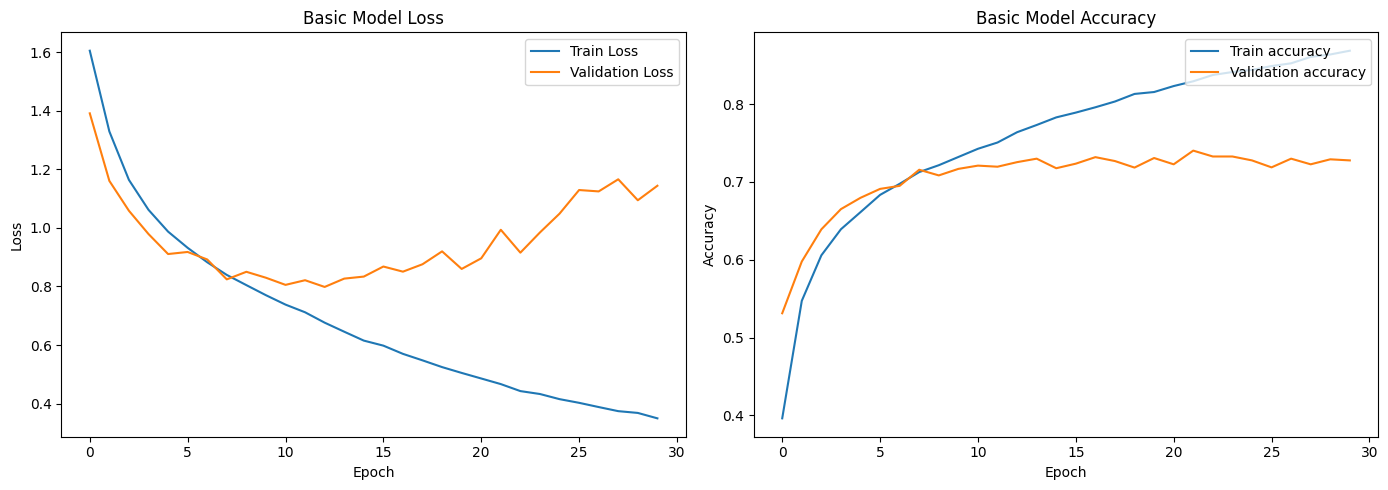

In [12]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(basic_model_history.history['loss'], label='Train Loss')
plt.plot(basic_model_history.history['val_loss'], label='Validation Loss')
plt.title('Basic Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(basic_model_history.history['accuracy'], label='Train accuracy')
plt.plot(basic_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Basic Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
# Get the prediction reusults
predictions = basic_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
test_labels, predicted_labels

112/112 [==============================] - 0s 2ms/step


(array([7, 3, 0, ..., 4, 1, 3]), array([0, 0, 0, ..., 0, 1, 3]))

In [14]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("Basic Model Accuracy:", accuracy)

Basic Model Accuracy: 0.71264689423615


## Confusion Matrix

Basic Model Confusion Matrix:
 [[985  84  15 142  31   1   4   0   0   0]
 [ 68 781  14  33  28   0   4   0   0   0]
 [ 52  34 320   7  21   0  10   0   0   0]
 [142  44   6 231  19   0   2   0   0   0]
 [ 56  31  16  26 192   2   2   0   0   0]
 [  2   1   2   6   5   7   0   0   0   0]
 [ 12  11  28  10   4   0  28   0   0   0]
 [ 14   4   0   4   2   0   0   3   0   0]
 [ 14   2   5   2   4   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0]]


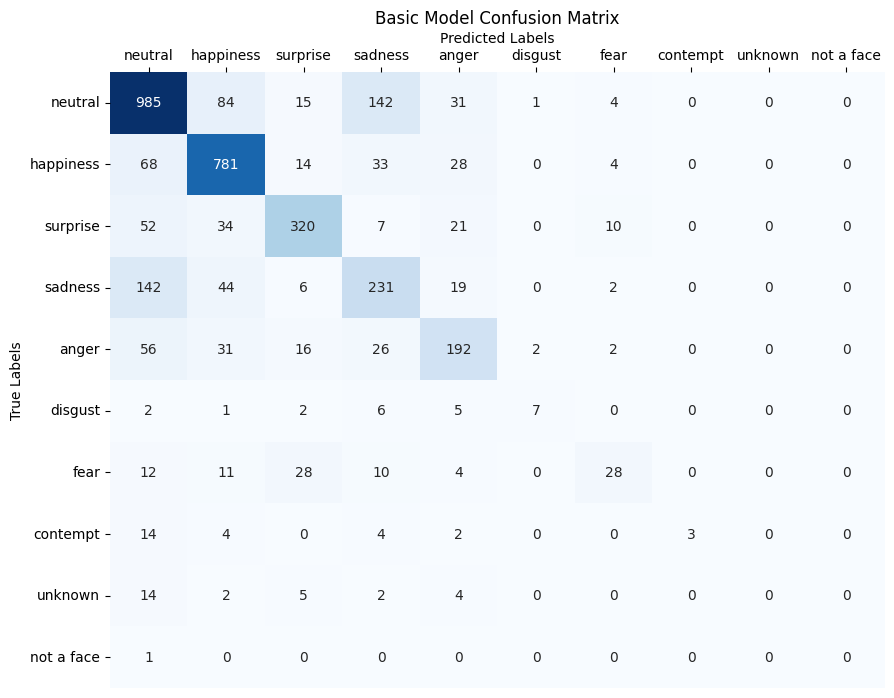

In [15]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
    5: "disgust",
    6: "fear",
    7: "contempt",
    8: "unknown",
    9: "not a face"
}

# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Basic Model Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Basic Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()

# Balanced data

## Load

In [16]:
# Read data form csv
balanced_train_df = pd.read_csv("data/relevant_train_df.csv")
balanced_valid_df = pd.read_csv("data/relevant_valid_df.csv")
balanced_test_df = pd.read_csv("data/relevant_test_df.csv")
balanced_train_df.shape, balanced_valid_df.shape, balanced_test_df.shape

((16981, 3), (2121, 3), (2103, 3))

In [17]:
# Load and normalize images
def load_images(data, base_path):
    images = []
    labels = []
    paths = []
    
    # Mapping from Usage to directory names
    directory_map = {
        "Training": "FER2013Train",
        "PublicTest": "FER2013Valid",
        "PrivateTest": "FER2013Test"
    }
    
    for idx, row in data.iterrows():
        directory = directory_map.get(row['Usage'], None)
        if directory:
            image_path = os.path.join(base_path, directory, row['Image name'])
            
            if os.path.exists(image_path):
                # Load the image
                image = Image.open(image_path).convert('L')  # Convert to grayscale
                image_array = np.array(image) / 255.0  # Normalize to 0-1
                
                # Append data
                images.append(image_array)
                labels.append(row['predominant_emotion_index'])  # Select emotion intensity columns
                paths.append(image_path)
    
    return np.array(images), np.array(labels), paths

# Base path for images
base_image_path = 'FERPlus-master/data'

# Load images and their labels
balanced_train_images, balanced_train_labels, balanced_train_image_paths = load_images(balanced_train_df, base_image_path)
balanced_valid_images, balanced_valid_labels, balanced_valid_image_paths = load_images(balanced_valid_df, base_image_path)
balanced_test_images, balanced_test_labels, balanced_test_image_paths = load_images(balanced_test_df, base_image_path)

# Check shapes and an example path
print("Train images shape:", balanced_train_images.shape, balanced_train_images.dtype)
print("Train labels shape:", balanced_train_labels.shape, balanced_train_labels.dtype)

print("Valid images shape:", balanced_valid_images.shape, balanced_valid_images.dtype)
print("Valid labels shape:", balanced_valid_labels.shape, balanced_valid_labels.dtype)

print("Tests images shape:", balanced_test_images.shape, balanced_test_images.dtype)
print("Tests labels shape:", balanced_test_labels.shape, balanced_test_labels.dtype)


Train images shape: (16981, 48, 48) float64
Train labels shape: (16981,) int64
Valid images shape: (2121, 48, 48) float64
Valid labels shape: (2121,) int64
Tests images shape: (2103, 48, 48) float64
Tests labels shape: (2103,) int64


# Basic CNN

In [18]:
# Create a basic CNN model
balanced_basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # first conv layer
    MaxPooling2D((2, 2)),  # first pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # second conv layer
    MaxPooling2D((2, 2)),  # second pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # third conv layer
    MaxPooling2D((2, 2)),  # third pooling layer
    Flatten(),  # flatten the output for the dense layer
    Dense(128, activation='relu'),  # fully connected layer
    Dropout(0.5),  # dropout for regularization
    Dense(10, activation='softmax')  # output layer with 10 units for each emotion
])

balanced_basic_model.summary()  # This will print the summary of the model architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

In [19]:
# Compile the model
balanced_basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Reshape images to add channel dimension for CNN

In [20]:
# Reshape or modify the data to add a channel dimension for CNNs, expect an input shape like (batch, height, width, channels)
# Channel dimension is 1 for grayscale images
balanced_train_images = balanced_train_images.reshape((-1, 48, 48, 1))
balanced_valid_images = balanced_valid_images.reshape((-1, 48, 48, 1))
balanced_test_images = balanced_test_images.reshape((-1, 48, 48, 1))

In [21]:
print("Train images shape:", balanced_train_images.shape, balanced_train_images.dtype)
print("Train labels shape:", balanced_train_labels.shape, balanced_train_labels.dtype)

print("Valid images shape:", balanced_valid_images.shape, balanced_valid_images.dtype)
print("Valid labels shape:", balanced_valid_labels.shape, balanced_valid_labels.dtype)

print("Tests images shape:", balanced_test_images.shape, balanced_test_images.dtype)
print("Tests labels shape:", balanced_test_labels.shape, balanced_test_labels.dtype)

Train images shape: (16981, 48, 48, 1) float64
Train labels shape: (16981,) int64
Valid images shape: (2121, 48, 48, 1) float64
Valid labels shape: (2121,) int64
Tests images shape: (2103, 48, 48, 1) float64
Tests labels shape: (2103,) int64


## Fit model

In [22]:
# Fit the model
balanced_basic_model_history = balanced_basic_model.fit(
    balanced_train_images, balanced_train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(balanced_valid_images, balanced_valid_labels)
)

Epoch 1/30
266/266 [==============================] - 3s 7ms/step - loss: 1.6231 - accuracy: 0.2622 - val_loss: 1.4155 - val_accuracy: 0.4069
Epoch 2/30
266/266 [==============================] - 2s 6ms/step - loss: 1.3731 - accuracy: 0.4308 - val_loss: 1.1922 - val_accuracy: 0.5200
Epoch 3/30
266/266 [==============================] - 2s 6ms/step - loss: 1.2105 - accuracy: 0.5146 - val_loss: 1.0585 - val_accuracy: 0.5719
Epoch 4/30
266/266 [==============================] - 2s 6ms/step - loss: 1.0927 - accuracy: 0.5574 - val_loss: 0.9535 - val_accuracy: 0.6256
Epoch 5/30
266/266 [==============================] - 2s 6ms/step - loss: 1.0101 - accuracy: 0.6030 - val_loss: 0.9098 - val_accuracy: 0.6492
Epoch 6/30
266/266 [==============================] - 2s 6ms/step - loss: 0.9529 - accuracy: 0.6255 - val_loss: 0.8918 - val_accuracy: 0.6497
Epoch 7/30
266/266 [==============================] - 1s 6ms/step - loss: 0.9022 - accuracy: 0.6465 - val_loss: 0.8354 - val_accuracy: 0.6690
Epoch 

## Save model

In [23]:
# Store the model to a .h5 file
balanced_basic_model.save('models/basic_model_balanced.keras')

## Load model

In [24]:
# Load the model from the .h5 file
#balanced_basic_model = load_model('models/basic_model_balanced.keras')

## Evaluate

In [25]:
# Evaluate the model
balanced_test_loss, balanced_test_acc = balanced_basic_model.evaluate(balanced_test_images, balanced_test_labels)
print("Basic Model Test Accuracy:", balanced_test_acc)

66/66 [==============================] - 0s 3ms/step - loss: 1.2313 - accuracy: 0.7014
Basic Model Test Accuracy: 0.7013790011405945


## Plot 

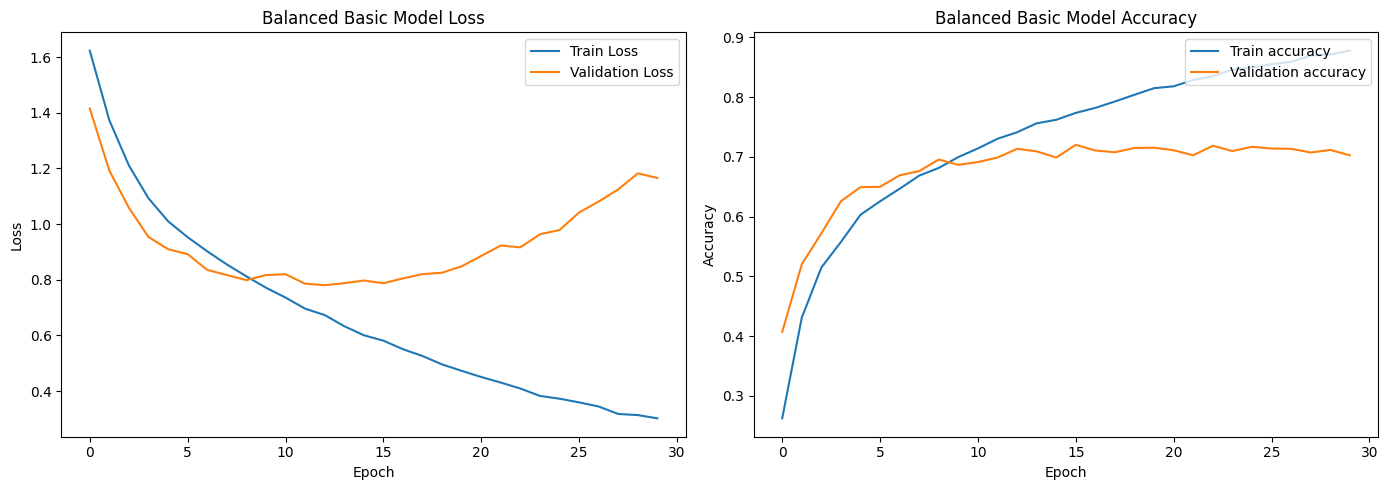

In [26]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(balanced_basic_model_history.history['loss'], label='Train Loss')
plt.plot(balanced_basic_model_history.history['val_loss'], label='Validation Loss')
plt.title('Balanced Basic Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(balanced_basic_model_history.history['accuracy'], label='Train accuracy')
plt.plot(balanced_basic_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Balanced Basic Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [27]:
# Get the prediction reusults
balanced_predictions = balanced_basic_model.predict(balanced_test_images)
balanced_predicted_labels = np.argmax(balanced_predictions, axis=1)
balanced_test_labels, balanced_predicted_labels

66/66 [==============================] - 0s 2ms/step


(array([3, 2, 4, ..., 4, 1, 3]), array([3, 4, 4, ..., 0, 1, 3]))

In [28]:
balanced_accuracy = accuracy_score(balanced_test_labels, balanced_predicted_labels)
print("Basic Model Accuracy:", balanced_accuracy)

Basic Model Accuracy: 0.7013789824060865


## Confusion Matrix

balanced Basic Model Confusion Matrix:
 [[296  22  27  85  32]
 [ 38 315  20  29  26]
 [ 26   5 377  13  23]
 [105  23  18 264  34]
 [ 32  20  23  27 223]]


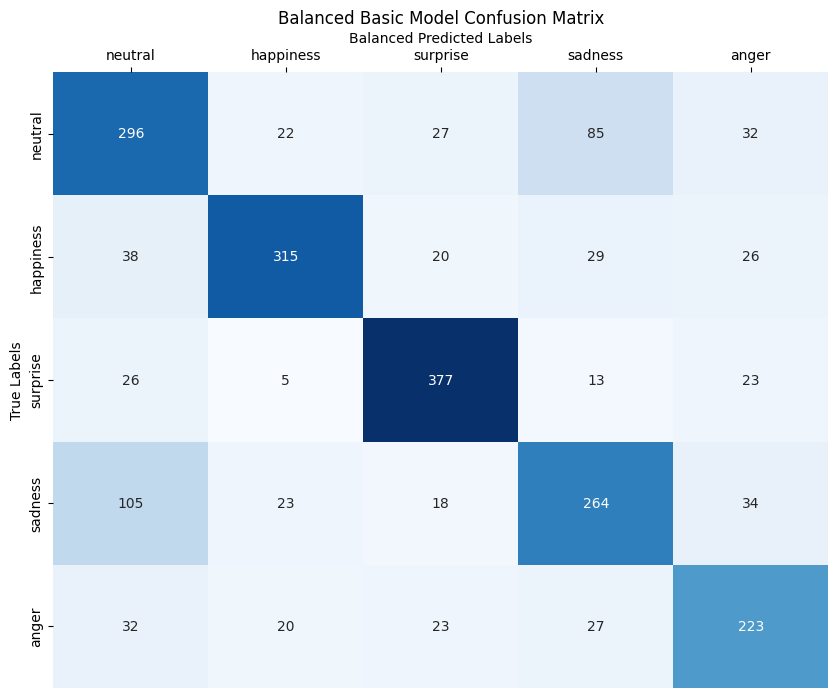

In [29]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
}

# Get the confusion matrix
balanced_conf_matrix = confusion_matrix(balanced_test_labels, balanced_predicted_labels)
print("balanced Basic Model Confusion Matrix:\n", balanced_conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(balanced_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Balanced Predicted Labels')
plt.ylabel('True Labels')
plt.title('Balanced Basic Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()